# 0. Colab Setup

In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content
!mkdir -p datasets/wikiart

Mounted at /content/gdrive
/content


In [ ]:
!cp /content/gdrive/MyDrive/Work/BlogData/Datasets/WikiArt/wikiart.zip datasets
!cp /content/gdrive/MyDrive/Work/BlogData/Datasets/WikiArt/wikiart_csv.zip datasets

In [ ]:
!unzip datasets/wikiart.zip -d datasets/wikiart
!unzip datasets/wikiart_csv.zip -d datasets/wikiart_csv

In [ ]:
!rm datasets/wikiart.zip
!rm datasets/wikiart_csv.zip

# 1. Data cleaning

In [ ]:
%cd datasets

In [ ]:
import pandas as pd
import numpy as np
import yaml
import os

In [ ]:

def read_class_txt(txt_file):
    # returns dictionary with key = id and value = label
    with open(txt_file) as f:
        lines = f.readlines()
        lines = [line.strip().split() for line in lines]
        classes_dict = dict(lines)
    return classes_dict 

In [ ]:
path_to_class_info = "/content/datasets/wikiart_csv"
artist_class = read_class_txt(os.path.join(path_to_class_info, 'artist_class.txt'))
genre_class = read_class_txt(os.path.join(path_to_class_info, 'genre_class.txt'))
style_class = read_class_txt(os.path.join(path_to_class_info, 'style_class.txt'))

In [ ]:
# change name because of data error
style_class['3']='Art_Nouveau_Modern'

In [ ]:
# first model is going to be to classify style
style_class

In [ ]:
# for label_type in ['artist', 'genre', 'style']:
#     for subset in ['train', 'val']:
#         pd.Dataframe(label_type+"_"+subset+".csv")


# 2. Model 

In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms as T
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

ImageFolder is structured like this:

```
# root/label/image.png
root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png
```
In our case:
```
wikiart
    wikiart
        train
            Abstract_Expressionism
                img1.jpg
            ...
        val
            Abstract_Expressionism
                imgX.jpg
            ...
```




In [ ]:

a = pd.read_csv("wikiart_csv/style_train.csv", header=None)
b = pd.read_csv("wikiart_csv/style_val.csv", header=None)
merged = a.append(b)
merged.dropna()
merged.to_csv("style.csv", header=None, index=False)
merged

In [ ]:
%cd /content/datasets/wikiart

In [ ]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler

class WikiArtDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, header=None, names=['file_path','label'])
        self.img_dir = img_dir
        self.transform = transform
        self.class_names = style_class
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, img_path

In [ ]:
transform = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )


wikiart_dataset = WikiArtDataset(
    '../style.csv', 
    'wikiart',
    transform=transform
)

In [ ]:
wikiart_dataset[0][0].shape

In [ ]:
dataset_size = len(wikiart_dataset)
idxs = list(range(dataset_size))

val_split = 0.2
shuffle = True
batch_size = 64

split = int(np.floor(val_split * dataset_size))
if shuffle :
    np.random.seed(1)
    np.random.shuffle(idxs)
train_indices, val_indices = idxs[split:], idxs[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(wikiart_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(wikiart_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

dataloaders = {
    'train': train_loader,
    'val': validation_loader
}


dataset_sizes = {
    'train': len(train_indices),
    'val': len(val_indices)
}


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes, img_paths = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            try:
                for inputs, labels, img_paths in tqdm(dataloaders[phase]):
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            # backward + optimize only if in training phase
                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        # statistics
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
            except RuntimeError:
                print("Error loading image in one of these images:" + img_paths + ".")
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, img_paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} true: {} img path: {}'.format(wikiart_dataset.class_names[str(preds[j].item())], \
                                                             wikiart_dataset.class_names[str(labels[j].item())], \
                                                             img_paths[j]
                                                             )
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:

model_ft = models.resnet18(pretrained=True, progress=True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(wikiart_dataset.class_names))

#continue from previoua best weights
model_ft.load_state_dict(torch.load('/content/gdrive/MyDrive/Work/BlogData/best_epoch11.pt'))

model_ft = model_ft.to(torch.device("cuda:0"))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


100%|██████████| 1019/1019 [28:09<00:00,  1.66s/it]


train Loss: 0.1277 Acc: 0.9701


  7%|▋         | 19/255 [00:30<06:18,  1.60s/it]


TypeError: ignored

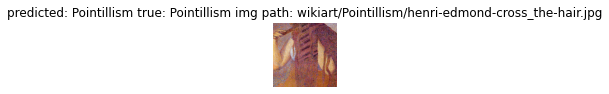

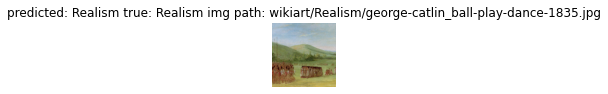

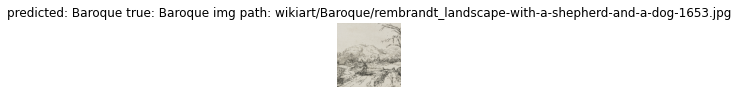

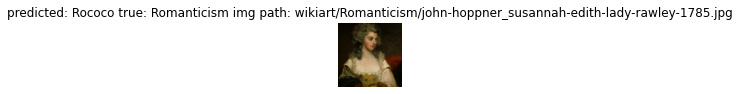

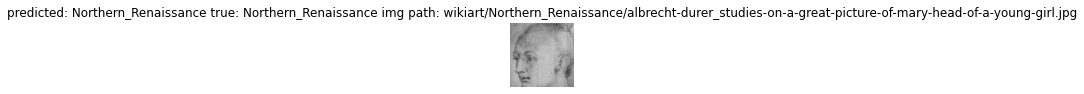

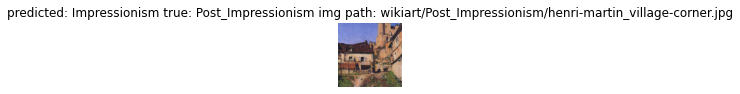

In [ ]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft.state_dict(), '/content/gdrive/MyDrive/Work/BlogData/best_epoch11.pt')

In [ ]:
aux = torch.load('/content/gdrive/MyDrive/Work/BlogData/best_epoch0.pt')
aux1 = torch.load('/content/gdrive/MyDrive/Work/BlogData/best_epoch1.pt')

In [ ]:
aux.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

AssertionError: ignored

In [ ]:
aux['layer4.1.bn2.running_mean']

tensor([-2.0040e-02, -5.5502e-02, -4.8008e-02, -3.7522e-02, -5.6584e-02,
        -2.6006e-02, -4.8615e-02, -3.1162e-02,  6.8295e-02, -2.8854e-02,
        -6.5960e-02, -3.3053e-03, -4.0731e-02, -6.5310e-03, -2.6999e-02,
        -2.1979e-02, -4.1503e-02, -7.5110e-02,  4.8543e-02, -3.4257e-02,
        -1.7841e-03, -7.9896e-02, -4.0240e-02, -5.1213e-02, -1.3272e-02,
        -2.3519e-03, -1.7678e-02, -4.6448e-02, -5.5405e-02, -6.3582e-02,
        -2.4701e-02, -6.4664e-02, -3.6682e-02, -4.2033e-02, -1.9993e-02,
        -5.0927e-02, -4.7094e-02, -6.9702e-02, -1.6908e-02, -4.7398e-02,
        -9.2493e-02, -2.4162e-02, -4.9332e-02,  1.0608e-02, -4.4722e-02,
        -4.6333e-02, -3.7276e-02,  4.7801e-02, -4.2847e-02, -2.7033e-02,
        -2.8021e-02, -8.4015e-03, -6.3775e-02, -3.1212e-02, -9.4152e-03,
        -3.0148e-02, -5.1226e-02, -4.8370e-04, -4.7573e-02, -5.0806e-02,
        -5.5891e-02, -2.1540e-02, -7.7253e-02, -7.7059e-02, -5.0097e-02,
        -4.7315e-02, -6.5418e-03, -7.4428e-02, -7.7

# 3. Optimization

In [4]:
# Based on tutorials
# https://www.google.com/search?client=safari&rls=en&q=pytorch+tutorial+optimise+inference+speed&ie=UTF-8&oe=UTF-8
# https://pytorch.org/tutorials/recipes/mobile_perf.html?highlight=mobile
# 
!pip install torch torchvision timm pandas requests

In [ ]:

# example on how to convert to torchscript in the following link
# https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html
# Steps
#   - Tracing
#   - 

traced_model = torch.jit.trace(model_ft, example_inputs=wikiart_dataset[0])
print(traced_model.code)
scripted_model = torch.jit.script(model_ft)
print(scripted_model.code)
scripted_model.save('/content/gdrive/MyDrive/Work/BlogData/scripted_best_epoch13.pt')
# Benefits of tracing
#   - Many requests can be processed at the same time (we can run in inference mode on several different )


# TODO Tracing vs Scripting? Major differences?

In [ ]:

loaded = torch.jit.load('/content/gdrive/MyDrive/Work/BlogData/scripted_best_epoch13.pt')

# 4. Serving

In [5]:
# install torchserve
!git clone git@github.com:pytorch/serve.git
!cd serve
# check cuda version in google colab 
!nvidia-smi



Cloning into 'serve'...
remote: Enumerating objects: 26775, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (49/49), done.
^Cceiving objects:  17% (4552/26775), 26.12 MiB | 4.13 MiB/s   
fetch-pack: unexpected disconnect while reading sideband packet
zsh:cd:1: no such file or directory: serve
zsh:1: command not found: nvidia-smi


In [ ]:

!python ./ts_scripts/install_dependencies.py --cuda=cu102

In [ ]:
# we need to run commands from the parent dir
!cd ..

In [ ]:
%%bash
mkdir model_store

In [ ]:
# insert model name here
# /content/gdrive/MyDrive/Work/BlogData/best_epoch12.pt
# MAR takes in a model in torchscript format


torch-model-archiver --model-name resnet18 --version 1.0 --model-file ./serve/examples/image_classifier/densenet_161/model.py --serialized-file densenet161-8d451a50.pth --export-path model_store \
    --extra-files ./serve/examples/image_classifier/index_to_name.json --handler image_classifier
